<a href="https://colab.research.google.com/github/Ambaright/ST-554-Project1/blob/main/Task3/ST554_Project_1_Task_3.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ST 554 Project 1: Task 3**


+
*Programmed by: Michelle Silveira*

**Introduction**
The increasing incidence of respiratory illness and the known carcinogenic risks associated with prolonged exposure to pollutants like benzene (C6H6(GT)) have made precise urban air quality monitoring a critical priority for public health and municipal traffic management. Currently, urban monitoring relies on sparse networks of fixed stations equipped with high-precision industrial spectrometers; however, the high cost and significant size of these instruments prevent the deployment of a monitoring mesh dense enough to capture the complex, turbulent diffusion of gases in a city environment. To address this gap, research has shifted toward low-cost gas multi-sensor devices, often termed "electronic noses," which utilize solid-state sensors to provide a more granular view of urban pollution.

The provided report examines data from a 13-month measurement campaign (March 2004 to April 2005) conducted along a high-traffic road in an Italian city. The study’s primary objective was to evaluate the feasibility of using these low-cost devices to "densify" existing monitoring networks by comparing their readings against "Ground Truth" (GT) reference data provided by a conventional monitoring station. The dataset includes hourly mean concentrations for several "true" pollutants - CO, NMHC, C6H6, NOx, and NO2 - recorded alongside the responses of five metal oxide chemoresistive sensors (targeted at CO, NMHC, NOx, NO2, and O3) and two sensors for weather-related variables, specifically temperature (T), relative humidity (RH), and absolute humidity (AH).

A central focus of this analysis is the estimation of C6H6(GT) (benzene). Notably, the multi-sensor device used in the study did not include a sensor specifically targeted at benzene. Instead, the study aimed to reconstruct benzene levels by employing artificial neural networks to exploit the significant linear correlations that exist between different urban pollutants. For instance, a very strong correlation coefficient of 0.98 was observed between benzene and Non-Metanic Hydrocarbons (NMHC).

Furthermore, the study investigates the critical role of atmospheric dynamics, as the stability and selectivity of solid-state sensors are heavily influenced by seasonal changes and weather variables. Earlier findings suggest that sensor performance can be impacted by rapid shifts in humidity and low temperatures, which may necessitate periodic re-calibration to account for sensor drift and changing gas mixture ratios in the winter. By conducting an Exploratory Data Analysis (EDA) on the relationships between sensor outputs, weather conditions, and benzene concentrations, this repor

**Reading in the Data**
In this section, the data is read in from [Air Quality Data](https://archive.ics.uci.edu/dataset/360/air+quality) and the features are extracted and stored into a saved DataFrame air. We then investigate the data to understand how it is stored using .head() and .info() methods. With .head() we can see what the first five rows of our data look like, and with .tail() we can see what the last five rows of our data look like. With .info() we can see the data types for each variable.

In [17]:
# Install ucimlrepo if you haven't already
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# Fetch dataset
air_quality = fetch_ucirepo(id=360)

# Extract the Features
air = air_quality.data.features
print(".head()")
print(air.head())
print("\n" + ".tail()")
print(air.tail())



.head()
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7

# Project 1 — Task 3: Time Series Cross-Validation for Benzene Prediction

In this task, we evaluate two competing regression models for predicting daily average benzene concentration (**C6H6(GT)**) using a **time-series (sequential) cross-validation** approach.

Why time-series CV?
- Our observations come from consecutive days.
- Days close in time tend to be correlated.
- Random cross-validation would leak information from the future into the past.

## Models
1. **SLR**: Use **CO(GT)** to predict **C6H6(GT)**
2. **MLR**: Use **CO(GT), T, RH, AH** to predict **C6H6(GT)**

## Cross-validation scheme (Expanding window)
- Train on days 1…250 → predict day 251 → compute MSE
- Train on days 1…251 → predict day 252 → compute MSE
- Continue until the final day
- Sum all step-ahead MSE values to get an overall CV error


In [18]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


## Basic cleaning

The UCI file sometimes includes extra empty columns at the end due to trailing separators.
We remove columns that are completely empty.


In [19]:
# Drop columns that are entirely missing (often "Unnamed: 15", "Unnamed: 16" etc.)
df=air
df = df.dropna(axis=1, how="all")
df.columns
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


## Remove rows with missing values in required columns

###Additional Data Cleaning for Task 3
The instructions ask us to remove observations where any of these variables equal **-200**:
- C6H6(GT), CO(GT), T, RH, AH

We will drop those rows before computing daily averages.


In [21]:
needed_cols = ["C6H6(GT)", "CO(GT)", "T", "RH", "AH"]

# Keep only rows where none of these columns equals -200
df_clean = df[(df[needed_cols] != -200).all(axis=1)].copy()

df_clean.shape


(7344, 15)

## Create the daily dataset (average by Date)

We now create a new dataset with:
- Date
- daily averages of C6H6(GT), CO(GT), T, RH, AH

This converts the original hourly series into a daily time series.
The expected final dataset should have about **347 days**.


In [22]:
# Create daily averages
daily_df = (
    df_clean.groupby("Date")[needed_cols]
    .mean()
    .reset_index()
)

# Convert Date to datetime
daily_df["Date"] = pd.to_datetime(daily_df["Date"], format="%m/%d/%Y")

# Sort chronologically
daily_df = daily_df.sort_values("Date").reset_index(drop=True)

# Create sequential Day variable AFTER sorting
daily_df["Day"] = range(1, len(daily_df) + 1)

daily_df.head(), daily_df.shape


(        Date   C6H6(GT)    CO(GT)          T         RH        AH  Day
 0 2004-03-10   8.450000  1.966667  12.033333  54.900000  0.765633    1
 1 2004-03-11   8.269565  2.239130   9.826087  64.230435  0.777039    2
 2 2004-03-12  12.177273  2.804545  11.618182  50.190909  0.665164    3
 3 2004-03-13  11.121739  2.695652  13.121739  50.682609  0.733013    4
 4 2004-03-14   9.830435  2.469565  16.182609  48.317391  0.849209    5,
 (347, 7))

## Define predictors (X) and response (y)

Response:
- **y = C6H6(GT)** (daily average benzene)

Predictors:
- **SLR** uses only CO(GT)
- **MLR** uses CO(GT), T, RH, AH


In [23]:
y = daily_df["C6H6(GT)"]

X_slr = daily_df[["CO(GT)"]] #vector with independent variables for a SLR contains just one variable CO by definition
X_mlr = daily_df[["CO(GT)", "T", "RH", "AH"]] # vector with multiple independent variables


## Helper function: one-step-ahead MSE

This function performs **one step** of our expanding-window evaluation:
- Train on days 1 through `day`
- Test on day `day + 1`
- Fit LinearRegression
- Predict next day and compute MSE


In [24]:
def one_step_mse(X, y, day):
    """
    Compute one-step-ahead MSE using an expanding training window.

    Parameters
    ----------
    X : pd.DataFrame
        Predictor data in time order (one row per day).
    y : pd.Series
        Response in time order (one value per day).
    day : int
        The last index (in iloc terms) included in the training set.
        The test set is the next row (day+1).

    Returns
    -------
    float
        Mean squared error for predicting day+1 from training up to day.
    """
    # Train on rows [0, day-1] if day is count, but here day is iloc index endpoint
    # We'll implement using iloc so that:
    # - training includes rows 0..day-1 when day is length
    # - and test is row day
    X_train = X.iloc[:day]
    y_train = y.iloc[:day]

    X_test = X.iloc[day:day+1]
    y_test = y.iloc[day:day+1]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred)


## Rolling/Sequential Cross-Validation Function

We now implement the full cross-validation:
- Start training at a chosen day (here 250)
- For each day, fit using all previous days (expanding window)
- Predict the next day
- Accumulate (sum) the MSE values


In [25]:
def rolling_cv_full(X, y, start_day=250):
    """
    Performs expanding-window time-series CV.

    Returns:
        total_mse  : sum of one-step MSE values
        avg_mse    : average one-step MSE
        step_mse   : list of MSE values over time
    """

    n_days = len(X)
    total_mse = 0.0
    step_mse = []

    for day in range(start_day, n_days):
        mse = one_step_mse(X, y, day)
        step_mse.append(mse)
        total_mse += mse

    avg_mse = total_mse / len(step_mse)

    return total_mse, avg_mse, step_mse



## Run time-series cross-validation for both models

We compute the total (summed) MSE for:
- SLR model
- MLR model

The lower value indicates better out-of-sample predictive performance.


In [26]:
total_slr, avg_slr, steps_slr = rolling_cv_full(X_slr, y, 250)
total_mlr, avg_mlr, steps_mlr = rolling_cv_full(X_mlr, y, 250)

print("SLR - Total MSE:", total_slr)
print("SLR - Average MSE:", avg_slr)

print("\nMLR - Total MSE:", total_mlr)
print("MLR - Average MSE:", avg_mlr)


SLR - Total MSE: 718.0810286685651
SLR - Average MSE: 7.402897202768712

MLR - Total MSE: 494.3422217646458
MLR - Average MSE: 5.096311564583977


## Model comparison and interpretation

- If the **MLR** model has a lower CV MSE than the **SLR**, it suggests that adding meteorological variables (T, RH, AH) improves benzene prediction.
- If the **SLR** is similar or better, then CO(GT) alone may be sufficient for prediction in this dataset.

Next, we select the model with the lower CV MSE and fit it using **all 347 days** to obtain our final regression model.


In [27]:
if total_mlr < total_slr:
    X_best = X_mlr
    best_name = "MLR: CO(GT) + T + RH + AH"
else:
    X_best = X_slr
    best_name = "SLR: CO(GT) only"

final_model = LinearRegression()
final_model.fit(X_best, y)

print("Best model based on rolling CV:", best_name)
print("Intercept:", final_model.intercept_)
print("Coefficients:", dict(zip(X_best.columns, final_model.coef_)))


Best model based on rolling CV: MLR: CO(GT) + T + RH + AH
Intercept: -1.8377694729981755
Coefficients: {'CO(GT)': np.float64(4.7708043290709945), 'T': np.float64(0.11973258636983058), 'RH': np.float64(-0.016202586785609402), 'AH': np.float64(0.6886681127493046)}


#Bonus Analysis graphical vision

Trying to visualize error over time

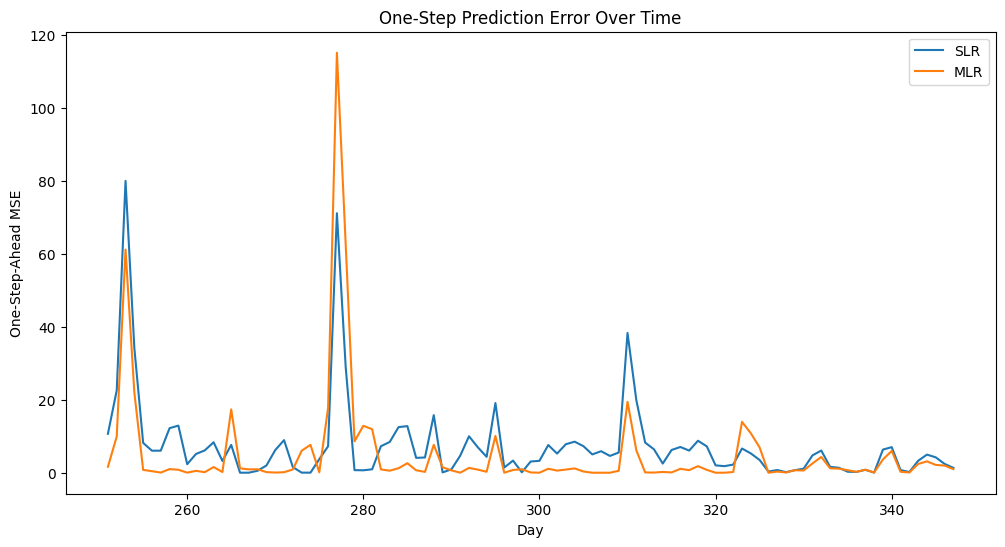

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(range(251, 251 + len(steps_slr)), steps_slr, label="SLR")
plt.plot(range(251, 251 + len(steps_mlr)), steps_mlr, label="MLR")

plt.xlabel("Day")
plt.ylabel("One-Step-Ahead MSE")
plt.title("One-Step Prediction Error Over Time")
plt.legend()
plt.show()


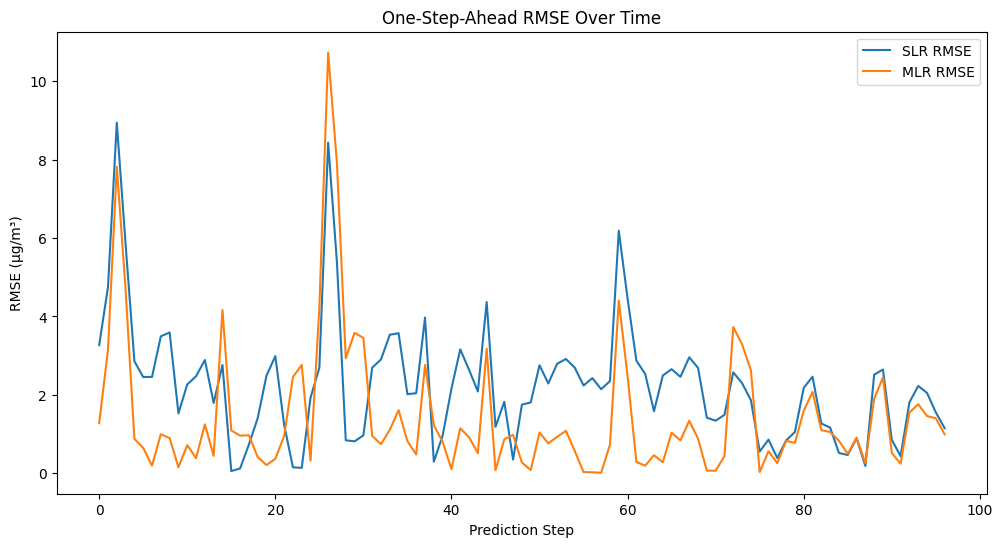

In [31]:
rmse_slr = np.sqrt(pd.Series(steps_slr))
rmse_mlr = np.sqrt(pd.Series(steps_mlr))

plt.figure(figsize=(12,6))
plt.plot(rmse_slr, label="SLR RMSE")
plt.plot(rmse_mlr, label="MLR RMSE")
plt.xlabel("Prediction Step")
plt.ylabel("RMSE (µg/m³)")
plt.title("One-Step-Ahead RMSE Over Time")
plt.legend()
plt.show()
